# Lib

In [5]:
import os
import os.path as osp
import sys
import time
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
from argparse import ArgumentParser

import torchreid
from torchreid.reid.utils import FeatureExtractor

import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


import plotly.express as px
import pandas as pd
from sklearn.manifold import TSNE


## Address def

In [2]:
raw_data_root = 'C:/Users/pt101/Desktop/EE-443-husky-team-spr24-master/data'

det_path = 'C:/Users/pt101/Desktop/EE-443-husky-team-spr24-master/txt'
exp_path = 'C:/Users/pt101/Desktop/EE-443-husky-team-spr24-master/runs/reid/inference'
reid_model_ckpt = 'C:/Users/pt101/Desktop/EE-443-husky-team-spr24-master/reid/osnet_x1_0_imagenet.pth'

## Feature Extraction 

In [9]:

W, H = 1920, 1080
data_list = {
    'train': ['camera_0001', 'camera_0003', 'camera_0011', 'camera_0013', 'camera_0020', 'camera_0021'],
    'test' : ['camera_0008', 'camera_0019', 'camera_0028'],
    'val'  : ['camera_0005', 'camera_0017', 'camera_0025']
}
sample_rate = 1 # because we want to test on all frames


val_transforms = T.Compose([
    T.Resize([256, 128]),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

reid_extractor = FeatureExtractor(
    model_name='osnet_x1_0',
    model_path=reid_model_ckpt,
    image_size=[256, 128],
    device='cuda' 
)   

for split in ['train']:
    for folder in data_list[split]:

        det_txt_path = os.path.join(det_path, f'{folder}.txt')
        print(f"Extracting feature from {det_txt_path}")

        dets = np.genfromtxt(det_txt_path, dtype=str,delimiter=',')

        # start extracting frame features
        cur_frame = 0
        emb = np.array([None] * len(dets)) # initialize the feature array

        for idx, (camera_id, _, frame_id, x, y, w, h, score, _) in enumerate(dets):
            
            x, y, w, h = map(float, [x, y, w, h])
            frame_id = str(int(frame_id)) # remove leading space
            
            if idx % 1000 == 0:
                print(f'Processing frame {frame_id} | {idx}/{len(dets)}')
            
            img_path = os.path.join(raw_data_root, split, folder, frame_id.zfill(5) + '.jpg')
            img = Image.open(img_path)

            img_crop = img.crop((x, y, x+w, y+h))
            img_crop = val_transforms(img_crop.convert('RGB')).unsqueeze(0)
            feature = reid_extractor(img_crop).cpu().detach().numpy()[0]

            feature = feature / np.linalg.norm(feature)
            emb[idx] = feature

        # check embedding dimension
        emb_save_path = os.path.join(exp_path, f'{folder}.npy')
        if not os.path.exists(exp_path):
            os.makedirs(exp_path)
        np.save(emb_save_path,emb)


# TODO 
# 1. You can try to extract features from the validation set since we have the ground truth labels
# 2. To determine how good the features, simply use the features to do the clustering and compare the clustering result with the ground truth labels

Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352
Successfully loaded pretrained weights from "C:/Users/pt101/Desktop/EE-443-husky-team-spr24-master/reid/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
Extracting feature from C:/Users/pt101/Desktop/EE-443-husky-team-spr24-master/runs/detect/inference/txt\camera_0001.txt
Processing frame 0 | 0/16025
Processing frame 103 | 1000/16025
Processing frame 194 | 2000/16025
Processing frame 282 | 3000/16025
Processing frame 371 | 4000/16025
Processing frame 456 | 5000/16025
Processing frame 586 | 6000/16025
Processing frame 711 | 7000/16025
Processing frame 875 | 8000/16025
Processing frame 1094 | 9000/16025
Processing frame 1241 | 10000/16025
Processing frame 1348 | 11000/16025
Processing frame 1433 | 12000/16025
Processing frame 1509 | 13000/16025
Processing frame 1600 | 14000/16025
Processing frame 1703 | 15000/16025
Processing frame 1797 | 

# Fetching the groundtruth

In [34]:
# Path to the text file
txt_file_path = 'C:/Users/pt101/Desktop/EE-443-husky-team-spr24-master/data/train/camera_0001.txt'
# Read the file and load the content into a numpy array
data = np.loadtxt(txt_file_path, delimiter=',').astype(int)
# Print the numpy array
print(data[0][2])
# Extract the second column (index 1)
second_column = data[:, 1]
# Find unique numbers in the second column
unique_numbers = np.unique(second_column)
# Count the number of unique numbers
unique_count = len(unique_numbers)
# Print the results
print("Unique numbers in the second column:", unique_numbers)
print("Number of unique numbers:", unique_count)

# Print the second column
print("Second column:", second_column)
print("Second column shape:", second_column.shape)




0
Unique numbers in the second column: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 23 24]
Number of unique numbers: 23
Second column: [ 3  4  5 ... 16 23 24]
Second column shape: (15671,)


4

In [38]:

#'train': ['camera_0001', 'camera_0003', 'camera_0011', 'camera_0013', 'camera_0020', 'camera_0021']
#load the numpy file
emb_save_path = 'C:/Users/pt101/Desktop/EE-443-husky-team-spr24-master/runs/reid/inference/camera_0001.npy'
emb = np.load(emb_save_path, allow_pickle=True)
print(emb.shape)
print(emb[0].shape)

emb2_save_path = 'C:/Users/pt101/Desktop/EE-443-husky-team-spr24-master/runs/reid/inference/camera_0003.npy'
emb2 = np.load(emb2_save_path, allow_pickle=True)
print(emb2.shape)
print(emb2[0].shape)


emb3_save_path = 'C:/Users/pt101/Desktop/EE-443-husky-team-spr24-master/runs/reid/inference/camera_0011.npy'
emb3 = np.load(emb3_save_path, allow_pickle=True)
print(emb3.shape)
print(emb3[0].shape)


(16025,)
(512,)
(11004,)
(512,)
(4375,)
(512,)


In [12]:
# Reshape 

# Load the numpy files
emb_save_path = 'C:/Users/pt101/Desktop/EE-443-husky-team-spr24-master/runs/reid/inference/camera_0001.npy'
emb = np.load(emb_save_path, allow_pickle=True)

reshaped_emb = np.stack(emb)
print(reshaped_emb.shape)  # This should now be (65885, 512)

# Similarly for other files
emb2_save_path = 'C:/Users/pt101/Desktop/EE-443-husky-team-spr24-master/runs/reid/inference/camera_0003.npy'
emb2 = np.load(emb2_save_path, allow_pickle=True)
reshaped_emb2 = np.stack(emb2)
print(reshaped_emb2.shape)  # This should now be (56137, 512)

emb3_save_path = 'C:/Users/pt101/Desktop/EE-443-husky-team-spr24-master/runs/reid/inference/camera_0011.npy'
emb3 = np.load(emb3_save_path, allow_pickle=True)
reshaped_emb3 = np.stack(emb3)
print(reshaped_emb3.shape)  # This should now be (45166, 512)


(16025, 512)
(11004, 512)
(4375, 512)


Combined shape: (16025, 512)
Cluster labels shape: (16025,)
Cluster centers shape: (23, 512)


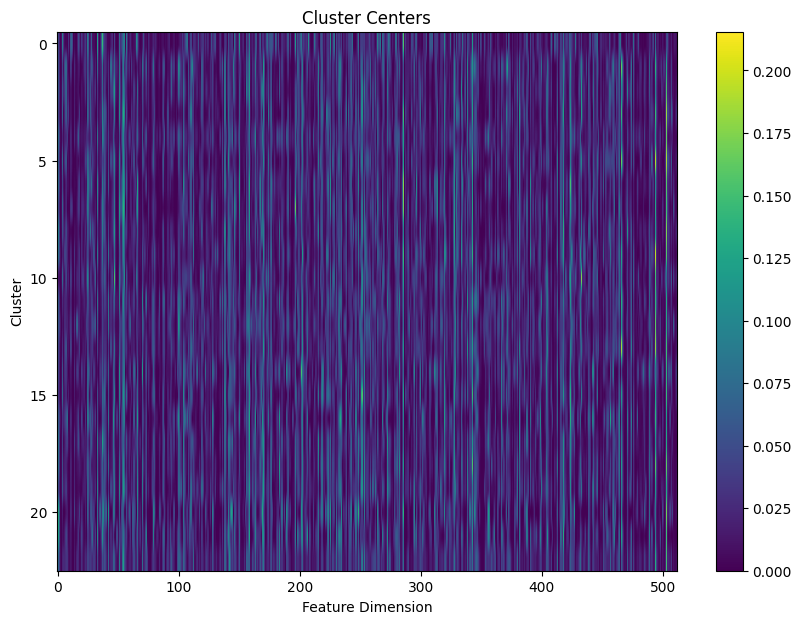

(16025,)
[ 8 17 13 ... 13  2  3]


In [26]:
# Combine all embeddings into one array
all_embeddings = np.concatenate([reshaped_emb, reshaped_emb2, reshaped_emb3])
print(f"Combined shape: {reshaped_emb.shape}")  # This should be (167188, 512)

# Number of clusters
num_clusters = 23  # You can choose the number of clusters based on your requirements

# Perform k-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(reshaped_emb)

# Get cluster labels
cluster_labels = kmeans.labels_
print(f"Cluster labels shape: {cluster_labels.shape}")  
print(f"Cluster centers shape: {kmeans.cluster_centers_.shape}")  # This should be (10, 512)
# Optionally, visualize the cluster centers
plt.figure(figsize=(10, 7))
plt.imshow(kmeans.cluster_centers_, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Cluster Centers')
plt.xlabel('Feature Dimension')
plt.ylabel('Cluster')
plt.show()

# Save cluster labels if needed
np.save('cluster_labels.npy', cluster_labels)





In [21]:


# Path to the text file
txt_file_path = 'C:/Users/pt101/Desktop/EE-443-husky-team-spr24-master/data/train/camera_0001.txt'
# Read the file and load the content into a numpy array
data = np.loadtxt(txt_file_path, delimiter=',')
# Print the numpy array
print(data[0][2])
# Extract the second column (index 1)
second_column = data[:, 1]
# Find unique numbers in the second column
unique_numbers = np.unique(second_column)
# Count the number of unique numbers
unique_count = len(unique_numbers)
# Print the results
print("Unique numbers in the second column:", unique_numbers)
print("Number of unique numbers:", unique_count)


0.0
Unique numbers in the second column: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 20. 21. 23. 24.]
Number of unique numbers: 23


In [53]:
# reduced_emb = pca.fit_transform(combined_emb)

# # Perform K-Means clustering
# kmeans = KMeans(n_clusters=10, random_state=42)
# kmeans.fit(reduced_emb)
# labels = kmeans.labels_
# centers = kmeans.cluster_centers_

# # Plot the clustering results
# plt.figure(figsize=(10, 6))
# plt.scatter(reduced_emb[:, 0], reduced_emb[:, 1], c=labels, s=10, cmap='tab10', alpha=0.6)
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, marker='X')
# plt.title('K-Means Clustering on PCA-Reduced Data')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.show()

In [54]:
# import os
# import shutil
# # Assuming you have a list of file paths corresponding to the embeddings
# file_paths = [
#     'path/to/image1.jpg', 'path/to/image2.jpg', # Add your image paths here
#     # ...
# ]

# # Create a directory to save cluster information
# cluster_dir = 'clusters'
# os.makedirs(cluster_dir, exist_ok=True)

# # Save images in corresponding cluster folders
# for idx, file_path in enumerate(file_paths):
#     cluster_id = cluster_labels[idx]
#     cluster_folder = os.path.join(cluster_dir, f'cluster_{cluster_id}')
#     os.makedirs(cluster_folder, exist_ok=True)
#     file_name = os.path.basename(file_path)
#     destination = os.path.join(cluster_folder, file_name)
#     shutil.copy(file_path, destination)

# print(f"Images have been organized into clusters and saved in '{cluster_dir}' directory.")


In [23]:


# Assuming you have combined_embeddings and cluster_labels from the previous steps

def calculate_cluster_statistics(embeddings, labels):
    unique_labels = np.unique(labels)
    
    cluster_ids = np.array(unique_labels)
    num_images_list = np.array([np.sum(labels == label) for label in unique_labels])
    mean_features_list = np.array([np.mean(embeddings[labels == label], axis=0) for label in unique_labels])
    std_features_list = np.array([np.std(embeddings[labels == label], axis=0) for label in unique_labels])
    
    return cluster_ids, num_images_list, mean_features_list, std_features_list

# Calculate the cluster statistics
cluster_ids, num_images_list, mean_features_list, std_features_list = calculate_cluster_statistics(reshaped_emb, cluster_labels)

# Check shapes
# print(cluster_ids.shape)
# print(num_images_list.shape)
# print(mean_features_list.shape)
# print(std_features_list.shape)
image_num_recheck = np.sum(num_images_list)
# Print the first few elements of each array for inspection
print("Cluster IDs:", cluster_ids)
print("Number of Images:", num_images_list)
# print("Mean Feature Vectors:", mean_features_list[:5, :5])  # Print first 5 elements of the first 5 vectors
# print("Standard Deviation of Feature Vectors:", std_features_list[:5, :5])  # Print first 5 elements of the first 5 vectors
print("Total number of images:", image_num_recheck)





Cluster IDs: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Number of Images: [ 271 1006 1609  700  914  627  651  520 1130  433  218  877  271 1075
  155  994  277 1075  895  669  290  369  999]
Total number of images: 16025


In [24]:


# Assuming you have combined_embeddings and cluster_labels from the previous steps

def calculate_cluster_statistics(embeddings, labels):
    unique_labels = np.unique(labels)
    statistics = {}
    
    for label in unique_labels:
        cluster_embeddings = embeddings[labels == label]
        statistics[label] = {
            'num_images': len(cluster_embeddings),
            'mean_feature': np.mean(cluster_embeddings, axis=0),
            'std_feature': np.std(cluster_embeddings, axis=0)
        }
    
    return statistics

cluster_statistics = calculate_cluster_statistics(reshaped_emb, cluster_labels)

# Print cluster statistics
for cluster_id, stats in cluster_statistics.items():
    print(f"Cluster {cluster_id}:")
    print(f"  Number of Images: {stats['num_images']}")
    print(f"  Mean Feature Vector: {stats['mean_feature'][:5]}...")  # Print first 5 elements for brevity
    print(f"  Standard Deviation of Feature Vector: {stats['std_feature'][:5]}...")  # Print first 5 elements for brevity


Cluster 0:
  Number of Images: 271
  Mean Feature Vector: [0.04213652 0.04474939 0.0020208  0.         0.08979077]...
  Standard Deviation of Feature Vector: [0.02753798 0.03205331 0.00643516 0.         0.05284646]...
Cluster 1:
  Number of Images: 1006
  Mean Feature Vector: [0.0082033  0.05815404 0.00149956 0.         0.04268499]...
  Standard Deviation of Feature Vector: [0.012766   0.02199383 0.00593541 0.         0.02552153]...
Cluster 2:
  Number of Images: 1609
  Mean Feature Vector: [0.00525535 0.06625376 0.0030107  0.         0.05541792]...
  Standard Deviation of Feature Vector: [0.01148841 0.03659628 0.0077317  0.         0.0316237 ]...
Cluster 3:
  Number of Images: 700
  Mean Feature Vector: [0.00602057 0.05038743 0.00058992 0.         0.0680308 ]...
  Standard Deviation of Feature Vector: [0.01097377 0.0281192  0.00366992 0.         0.02857213]...
Cluster 4:
  Number of Images: 914
  Mean Feature Vector: [0.00425044 0.08600263 0.00685613 0.         0.02307851]...
  Standa

In [25]:

# Assuming you have combined_embeddings and cluster_labels from the previous steps

# Reduce dimensionality for visualization
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(reshaped_emb)

# Create a DataFrame for interactive plotting
df = pd.DataFrame({
    't-SNE 1': embeddings_2d[:, 0],
    't-SNE 2': embeddings_2d[:, 1],
    'Cluster': cluster_labels
})

# Plot using Plotly
fig = px.scatter(df, x='t-SNE 1', y='t-SNE 2', color='Cluster', title='t-SNE Visualization of Clusters')
fig.show()


In [36]:
# Load the cluster labels
cluster_labels = np.load('cluster_labels.npy')
print (cluster_labels.shape)

second_column.shape






(16025,)


(15671,)